## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')

In [2]:
from scipy.fft import fft, fftfreq, fftshift

In [3]:
from scipy import signal
from scipy.integrate import cumtrapz

In [4]:
from buoy_methods import *

## Wave Modeling

### Types of Waves and Characteristics

### Deep vs Shallow

### Data Segmenting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1024 non-null   float64
 1   Ax      1024 non-null   float64
 2   Ay      1024 non-null   float64
 3   Az      1024 non-null   float64
 4   wx      1024 non-null   float64
 5   wy      1024 non-null   float64
 6   wz      1024 non-null   float64
 7   Bx      1024 non-null   float64
 8   By      1024 non-null   float64
 9   Bz      1024 non-null   float64
 10  qw      1024 non-null   float64
 11  qx      1024 non-null   float64
 12  qy      1024 non-null   float64
 13  qz      1024 non-null   float64
dtypes: float64(14)
memory usage: 112.1 KB
None


Text(0.5, 0, 'time (ms)')

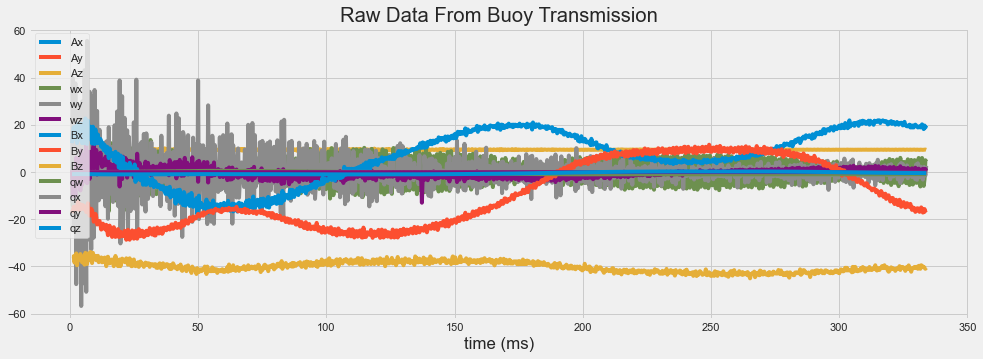

In [5]:
df  =  pd.read_csv("data/moving in water 2.csv")
#print(df.head())
print(df.info())
ax = df.plot(x='t', title="Raw Data From Buoy Transmission")
ax.set_xlabel("time (ms)")

### Mean Removal and Smoothing

Text(0.5, 0, 'time (ms)')

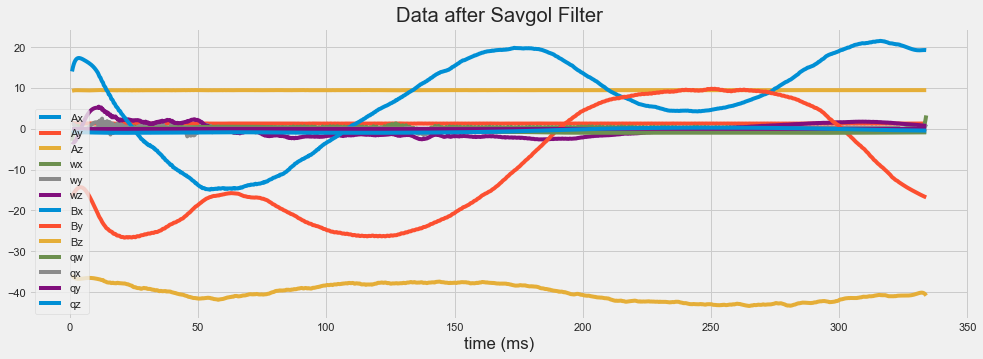

In [6]:
i=1
while i:
    try:
        df = df.apply(signal.savgol_filter, args=(63,6)) #x, window_length, polyorder,
    except:
        continue
    i=0
ax = df.plot(x='t', title="Data after Savgol Filter")
ax.set_xlabel("time (ms)")

Text(0.5, 0, 'time (ms)')

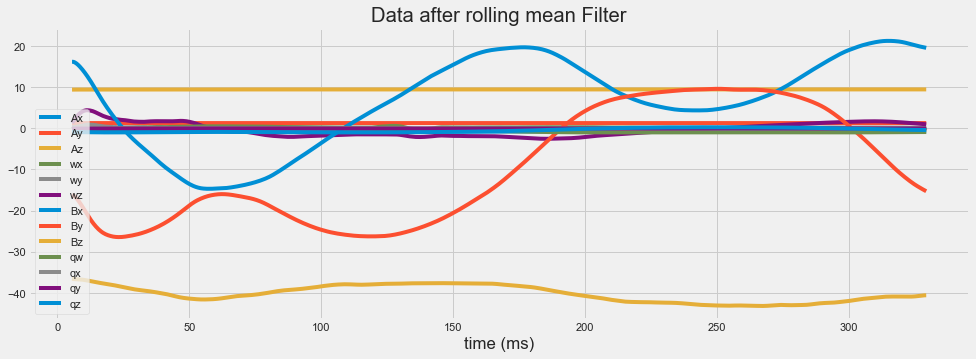

In [7]:
df = df.rolling(30).mean()
ax = df.plot(x='t', title="Data after rolling mean Filter")
ax.set_xlabel("time (ms)")

In [8]:
df.dropna(inplace=True)
acc = df.iloc[:,1:4].to_numpy()
gyr = df.iloc[:,4:7].to_numpy()
mag = df.iloc[:,7:10].to_numpy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 29 to 1023
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       995 non-null    float64
 1   Ax      995 non-null    float64
 2   Ay      995 non-null    float64
 3   Az      995 non-null    float64
 4   wx      995 non-null    float64
 5   wy      995 non-null    float64
 6   wz      995 non-null    float64
 7   Bx      995 non-null    float64
 8   By      995 non-null    float64
 9   Bz      995 non-null    float64
 10  qw      995 non-null    float64
 11  qx      995 non-null    float64
 12  qy      995 non-null    float64
 13  qz      995 non-null    float64
dtypes: float64(14)
memory usage: 116.6 KB


In [10]:
df.head()

,t,Ax,Ay,Az,wx,wy,wz,Bx,By,Bz,qw,qx,qy,qz
29,5.521257,-0.721227,1.289522,9.397786,-0.167146,0.301845,1.317151,16.162137,-16.063176,-36.570505,-0.437927,0.000895,-0.079606,-0.893556
30,5.846972,-0.734538,1.280665,9.402844,-0.066187,0.315620,1.595614,16.161114,-16.191215,-36.600376,-0.433260,0.002429,-0.079548,-0.895413
31,6.172684,-0.743471,1.274683,9.406260,-0.009120,0.327810,1.879310,16.116891,-16.346037,-36.622663,-0.427941,0.003657,-0.079466,-0.897519
32,6.498391,-0.747759,1.272414,9.407694,0.016415,0.292898,2.172112,16.031522,-16.529247,-36.638931,-0.421958,0.004591,-0.079378,-0.899879
33,6.824096,-0.749516,1.271342,9.408989,-0.006240,0.331991,2.449417,15.912235,-16.736643,-36.651855,-0.415317,0.005369,-0.079261,-0.902486


### Direction Definitions

Text(0.5, 0, 'time (ms)')

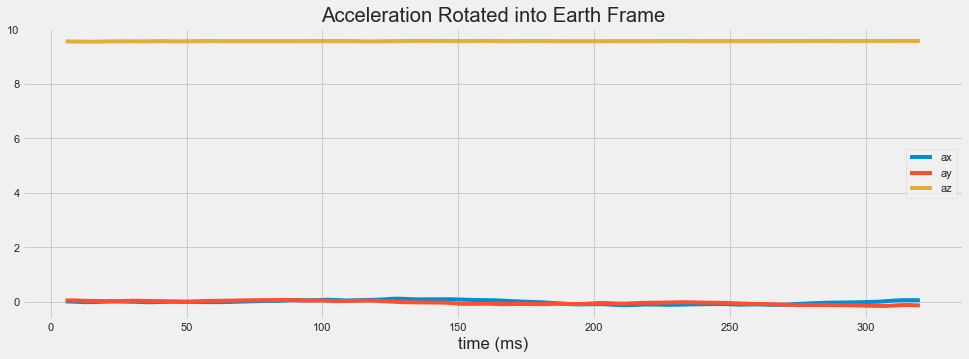

In [11]:
quate = []
for i in range(len(df.qx)):
    quate.append(Quaternion([df.qw.iloc[i],df.qx.iloc[i],df.qy.iloc[i],df.qz.iloc[i]]))
a=[]
for i, q in enumerate(quate):
    a.append(q.rotate_vector(acc[i]))
ef = pd.DataFrame(a,columns=['ax','ay','az']) # earth frame
ef['t'] = df.t
ax = ef.plot(x='t', title='Acceleration Rotated into Earth Frame')
ax.set_xlabel("time (ms)")

In [12]:
ef.az[0:600].mean()

9.553165272755683

In [13]:
ef.ax[0:600].mean()

0.028799665648603902

In [14]:
efnorm = ef.copy() # normalized for gravity
efnorm.az += -ef.az[0:600].mean()


Text(0, 0.5, 'acceleration $(m/s^2)$')

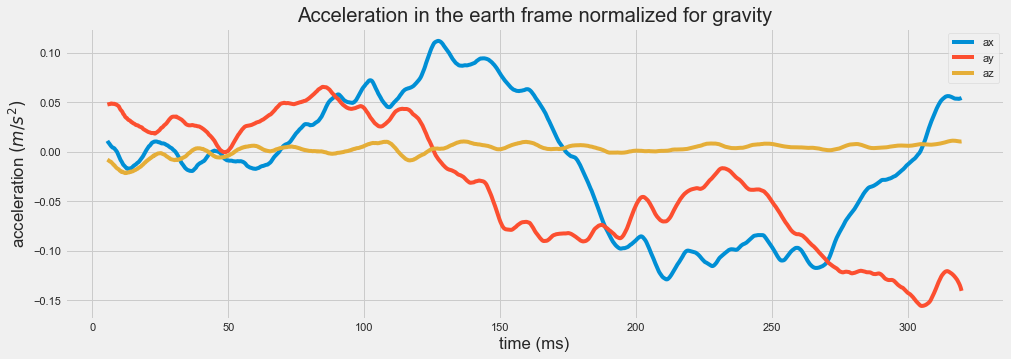

In [15]:
ax = efnorm.plot(x='t',title='Acceleration in the earth frame normalized for gravity')
ax.set_xlabel("time (ms)")
ax.set_ylabel(r"acceleration $(m/s^2)$")

### Integration

In [16]:
dt = np.round(df.t.diff().mean(),decimals=2)*0.001
dt #seconds

0.00033

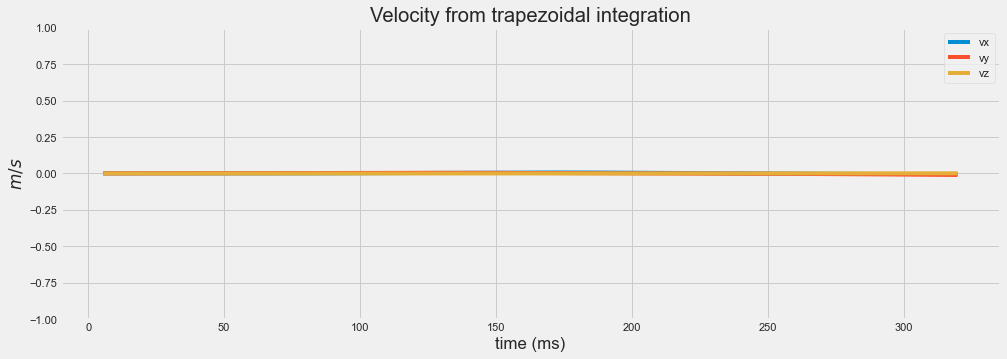

In [17]:
vx = cumtrapz(efnorm.iloc[:, 0], dx=dt)
vy = cumtrapz(efnorm.iloc[:, 1], dx=dt)
vz = cumtrapz(efnorm.iloc[:, 2], dx=dt)
fig, ax = plt.subplots()
ax.plot(efnorm.t[1:], vx, label='vx')
ax.plot(efnorm.t[1:], vy, label='vy')
ax.plot(efnorm.t[1:], vz, label='vz')
ax.set_ylim(-1,1)
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'$m/s$')
ax.set_title("Velocity from trapezoidal integration")
ax.legend()

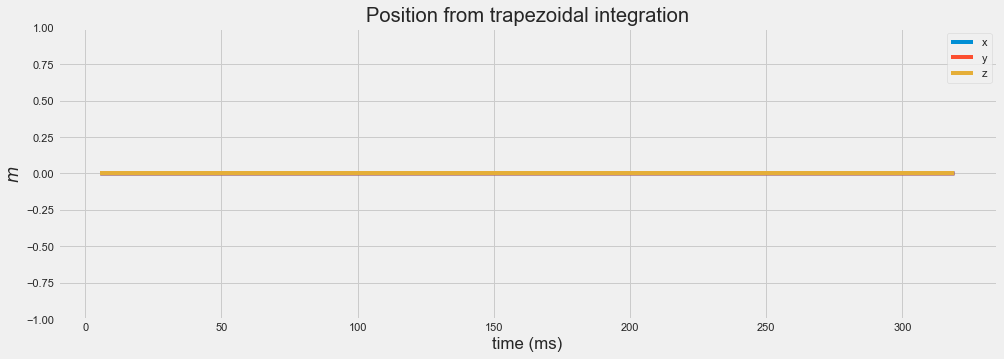

In [18]:
x = cumtrapz(vx, dx=dt)
y = cumtrapz(vy, dx=dt)
z = cumtrapz(vz, dx=dt)
position = pd.DataFrame([x, y, z]).T
position.columns= ['x','y','z']
position['t'] = efnorm.t[2:] # shorter from integration
ax1 = position.plot(x='t')
ax1.set_ylim(-1,1)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel(r'$m$')
ax1.set_title("Position from trapezoidal integration")
ax1.legend()

### Sea State

## Frequency and Direction Analysis

### Modeling

### FFT

In [19]:
Fx = fftshift(fft(efnorm.ax.values))
Fy = fftshift(fft(efnorm.ay.values))
Fz = fftshift(fft(efnorm.az.values))
freq = fftshift(fftfreq(df.t.shape[-1],d=dt)) # Hz

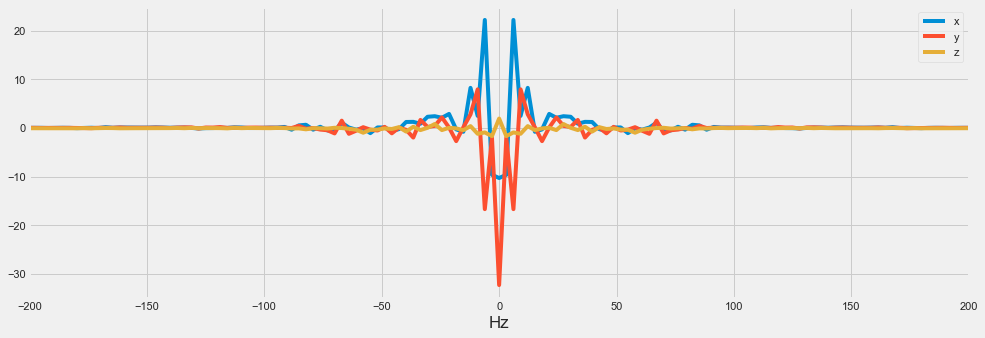

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('Hz')
ax.plot(freq, Fx.real, label='x')
ax.plot(freq, Fy.real, label='y')
ax.plot(freq, Fz.real, label='z')
ax.set_xlim([-200,200])
ax.legend()
plt.show()


\subsection{Cross Spectral Analysis}

Cross spectral analysis compares time series in the frequency basis to find similar peaks for orthogonal sets such as x and y data.



\begin{gather*}
x\ =\ \overline{x} +\sum ^{N/2}_{-N/2}\{F_{x}( k)\}\\
y\ =\ \overline{y} +\sum ^{N/2}_{-N/2}\{F_{y}( k)\}
\end{gather*}



\begin{equation*}
F_{x}( k) \ =C_{xk} e^{i\theta _{xk}} \ e^{i\frac{2\pi }{T} kt} =\ \ \frac{1}{2}( A_{xk} -iB_{xk}) e^{i\frac{2\pi }{T} kt}
\end{equation*}


The covariance is given by



\begin{gather*}
\overline{x'y'} =Real\left\{\sum ^{N/2}_{-N/2} F_{xy}( k)\right\}\\
F_{xy}( k) \ =\ F_{x}( k) \cdotp F^{*}_{y}( k) \ =\ C_{xk} C_{yk} e^{i( \theta _{xk} -\theta _{yk})}\\
=\ \frac{1}{2}( A_{xk} -iB_{xk}) e^{i\frac{2\pi }{T} kt}\frac{1}{2}( A_{yk} +iB_{yk}) e^{-i\frac{2\pi }{T} kt}\\
=\frac{1}{4}\{A_{xk} A_{yk} +B_{xk} B_{yk} +\ i( A_{xk} B_{yk} -A_{yk} B_{xk})\}
\end{gather*}




\begin{gather*}
co-spectra\ =\ A_{xk} A_{yk} +B_{xk} B_{yk}\\
quad-spectra\ =\ A_{xk} B_{yk} -A_{yk} B_{xk}
\end{gather*}

In [21]:
def co_spectrum(A1, A2):
    return A1.real * A2.real + A1.imag * A2.imag
def quad_spectrum(A1, A2):
    return A1.real * A2.imag - A1.imag * A2.real

In [22]:
A = [Fx, Fy, Fz]

In [23]:
C = pd.DataFrame()
Q = pd.DataFrame()
coords = ['x', 'y', 'z']
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        C[coords[i] + coords[j]] = co_spectrum(A[i], A[j])
    # print(C.info())
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        Q[coords[i] + coords[j]] = quad_spectrum(A[i], A[j])

    # These are not used for waves. These describe eddies
Q['xy'] = 0.0
Q['yx'] = 0.0

(-200.0, 200.0)

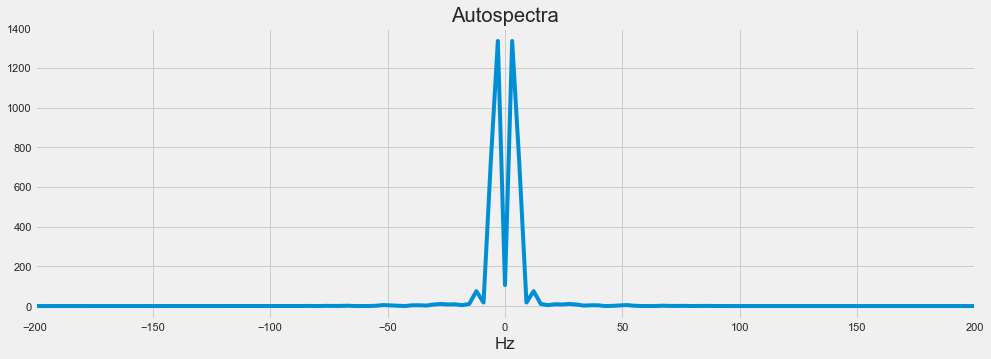

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel('Hz')
ax.set_title("Autospectra")
ax.plot(freq, C.xx)
ax.set_xlim([-200,200])

(-200.0, 200.0)

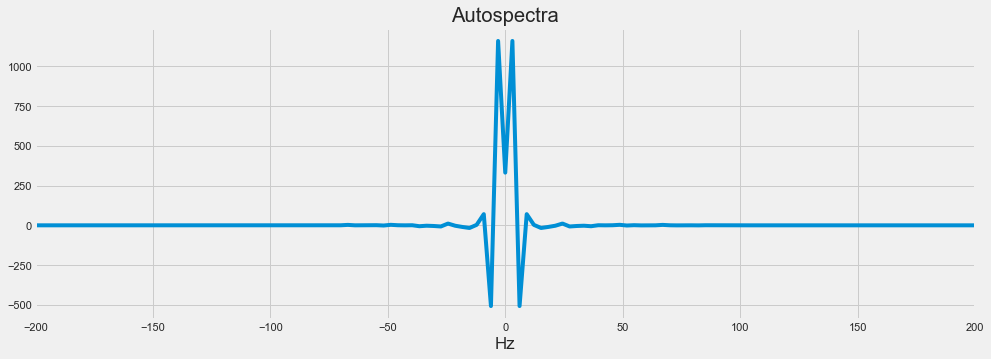

In [25]:
fig, ax = plt.subplots()
ax.plot(freq,C.xy)
ax.set_xlabel('Hz')
ax.set_title("Autospectra")
ax.set_xlim([-200,200])

(-200.0, 200.0)

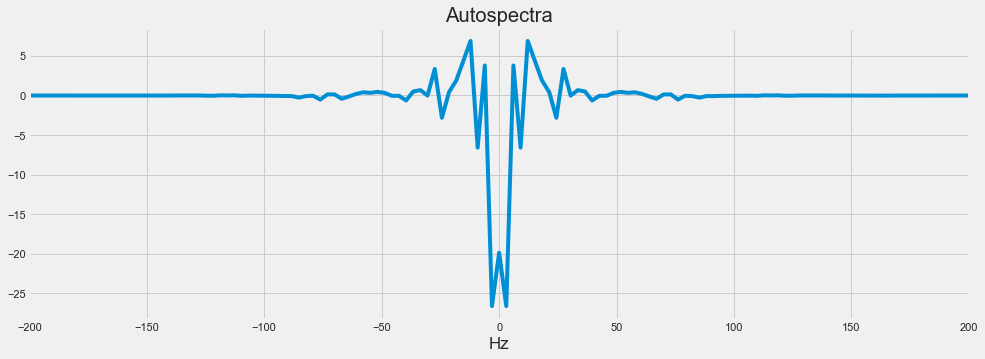

In [26]:
fig, ax = plt.subplots()
ax.plot(freq,C.xz)
ax.set_xlabel('Hz')
ax.set_title("Autospectra")
ax.set_xlim([-200,200])

Text(0.5, 1.0, 'Quad Spectra')

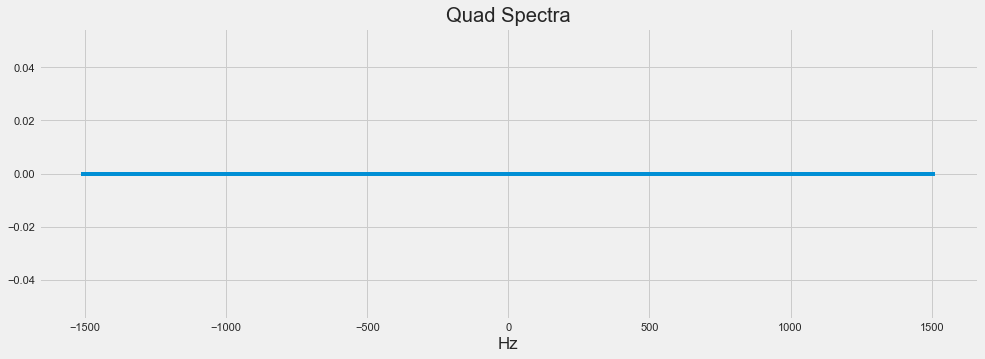

In [27]:
fig, ax = plt.subplots()
ax.plot(freq,Q.xy)
ax.set_xlabel('Hz')
ax.set_title("Quad Spectra")

(-200.0, 200.0)

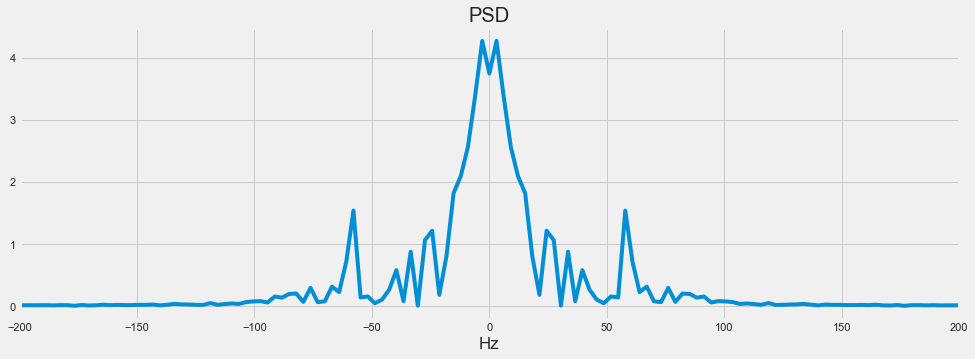

In [28]:
fig, ax = plt.subplots()
ax.plot(freq,C.zz)
ax.set_xlabel('Hz')
ax.set_title("PSD")
ax.set_xlim([-200,200])

\subsection{Circular Moments and Directional Distribution}

The primary (most informative) description of the sea state is the normalized directional distribution of energy per frequency $\displaystyle D_{f}( \theta ) .$ This can be obtained from the first four terms of a fourier series derived from the pitch and roll data of the buoy [Longuet-Higgins, Kuik]. First, the first four angular moments are calculated:

\begin{gather*}
a_{1} =\frac{Q_{yz}}{\sqrt{( C_{yy} +C_{xx}) C_{zz}}}\\
b_{1} =\frac{-Q_{xz}}{\sqrt{( C_{yy} +C_{xx}) C_{zz}}}\\
a_{2} \ =\ \frac{{C_{yy} -C_{xx}}}{C_{yy} +C_{xx}}\\
b_{2} \ =\ \frac{-2C_{y} x}{C_{yy} +C_{xx}}
\end{gather*}

In [29]:
a1 = Q.xz / (np.sqrt((C.zz + C.yy) * C.zz))
b1 = -Q.yz / ((np.sqrt((C.zz + C.yy) * C.zz)))  # possibly not negative
a2 = (C.xx - C.yy) / (C.xx + C.yy)
b2 = - 2 * C.xy / (C.xx + C.yy)  # possibly not negative

### Mean, Width, Skewness and Kurtosis